In [16]:
import utility_common as common
import utility_commonPlot as commonp
from fit_tcmodel import *

from timeit import default_timer as timer

# 1. Load Input-Label and Model

In [17]:
baseDir = common.getBaseDirectory()
shaping = True

if shaping:
    X = np.load(baseDir + "data/templates/shaping_signalRegion/X_.npy")
    X1 = np.load(baseDir + "data/templates/shaping_controlRegion/X_.npy")
else:
    X = np.load(baseDir + "data/templates/counting_signalRegion/X_.npy")
    X1 = np.load(baseDir + "data/templates/counting_controlRegion/X_.npy")

X  = tc.from_numpy(X ).type(tc.FloatTensor ).to(device)
X1 = tc.from_numpy(X1).type(tc.FloatTensor ).to(device)   
Y  = tc.sum(X ,1).to(device) + 0.1
Y1 = tc.sum(X1,1).to(device) + 0.1


# Model and optimizer
model     = TCPredictiveModel(True).to(device)
optimizer = tc.optim.LBFGS( model.parameters(),
                            lr=1, max_iter=50)

# 2. Training 

In [18]:
losses = []
# define backprop step
def closure():
    optimizer.zero_grad()
    y,regu,y1 = model.forward(X,X1)
    loss  = tc.sum( (y -Y )**2/(2*Y ) ) 
    loss += tc.sum( (y1-Y1)**2/(2*Y1) ) 
    loss += regu
    losses.append(loss)
    loss.backward(retain_graph=True) 
    return loss
# run optimization
start = timer()
optimizer.step(closure)
end = timer()
print('fitting time = {:6.4f} ms'.format( (end-start)*1000 ))

fitting time = 740.2724 ms


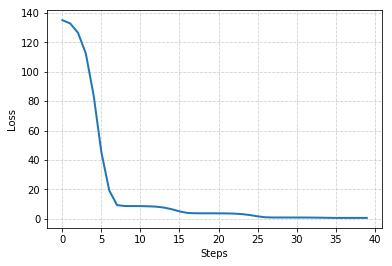

In [19]:
commonp.showLossHistory(losses[10:])
plt.savefig('../plots/fit/optimizaing')

# 3. Calculate Hessian of Loss

hessian time = 945.3116 ms


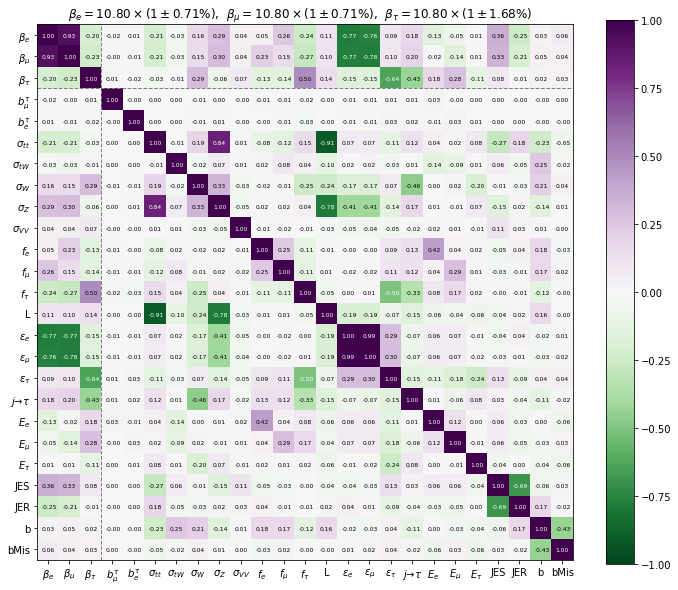

In [20]:
# forward prop X
y,regu,y1 = model.forward(X,X1)
# calculate loss and params
loss  = tc.sum( (y -Y )**2/(2*Y ) ) 
loss += tc.sum( (y1-Y1)**2/(2*Y1) ) 
loss += regu
# autograd loss w.r.t. params
start = timer()
hess = autograd2nd(loss, model)
end = timer()
print('hessian time = {:6.4f} ms'.format( (end-start)*1000 ))

hessinv = np.linalg.inv(hess)
sig = np.sqrt(hessinv.diagonal())
cor = hessinv/np.outer(sig, sig)

# show correlation and sigma
commonp.showParameterCovMat(cor,sig)

In [15]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name,param.data)
        
print(sig[0:3]/0.1080*100)
print(sig[3:])

layer_beta.params tensor([0.1081, 0.1081, 0.1081])
layer_btl.params tensor([0.0617, 0.0332])
layer_xs.params tensor([ 0.0436,  0.0156,  0.1201,  0.0675,  0.0278, -0.0213, -0.0014,  0.0007,
        -0.0941])
layer_eff.params tensor([-0.0555, -0.0544,  0.0105, -0.0194])
layer_itp.params tensor([ 0.0005, -0.0129, -0.0163,  0.0053, -0.0072, -0.0012,  0.0920])
[0.71106012 0.70985    1.67458963]
[0.99894365 0.99733287 0.4266387  0.91636683 0.75831319 0.43729007
 0.98717473 0.36800647 0.16478278 0.17159262 0.77483551 0.64289168
 0.64178126 0.36019848 0.29243946 0.18318972 0.34055783 0.25931874
 0.12542849 0.22699117 0.02900686 0.63940358]
